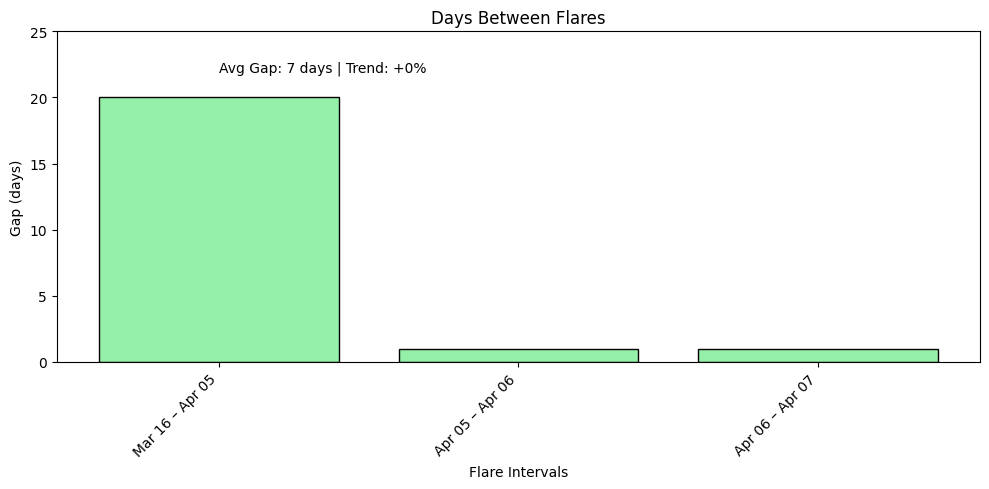

{'avg_gap': 7,
 'recent_trend': np.float64(0.0),
 'gap_days': [20, 1, 1],
 'gap_labels': ['Mar 16 – Apr 05', 'Apr 05 – Apr 06', 'Apr 06 – Apr 07']}

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from app.core.flares import calculate_flare_gaps  # already doing correct gap logic

def plot_flare_gap_chart(df: pd.DataFrame, severity_threshold: int = 4):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['severity'] = pd.to_numeric(df['severity'], errors='coerce')

    # Identify flare days
    df['is_flare'] = df['severity'] > severity_threshold
    flare_days = df[df['is_flare']]['date'].sort_values().reset_index(drop=True)

    # Calculate gaps
    gap_days = flare_days.diff().dropna().dt.days
    gap_labels = [
        f"{flare_days[i-1].strftime('%b %d')} – {flare_days[i].strftime('%b %d')}"
        for i in range(1, len(flare_days))
    ]

    # Calculate metrics
    avg_gap = int(gap_days.mean()) if not gap_days.empty else 0
    recent_trend = (
        ((gap_days.iloc[-1] - gap_days.iloc[-2]) / gap_days.iloc[-2]) * 100
        if len(gap_days) >= 2 else 0
    )

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(gap_labels, gap_days, color="#94f0a8", edgecolor="black")
    plt.title("Days Between Flares")
    plt.xlabel("Flare Intervals")
    plt.ylabel("Gap (days)")
    plt.ylim(0, max(gap_days.max() + 5, 10))
    plt.xticks(rotation=45, ha='right')

    # Add summary above chart or use as separate UI text
    plt.text(0, max(gap_days) + 2, f"Avg Gap: {avg_gap} days | Trend: {recent_trend:+.0f}%", fontsize=10)

    plt.tight_layout()
    plt.show()

    return {
        "avg_gap": avg_gap,
        "recent_trend": round(recent_trend, 1),
        "gap_days": gap_days.tolist(),
        "gap_labels": gap_labels
    }

# Example usage
df = pd.read_json("notional_data.json")
plot_flare_gap_chart(df)


<Axes: >

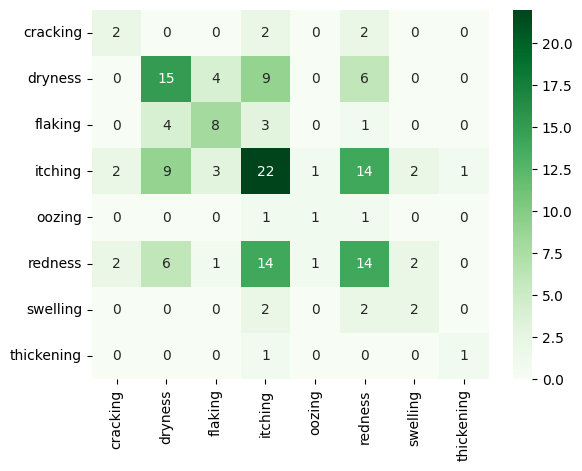

In [ ]:
import seaborn as sns
from app.core.symptoms import compute_matrix

matrix = compute_matrix(df)
sns.heatmap(matrix, annot=True, cmap="Greens")


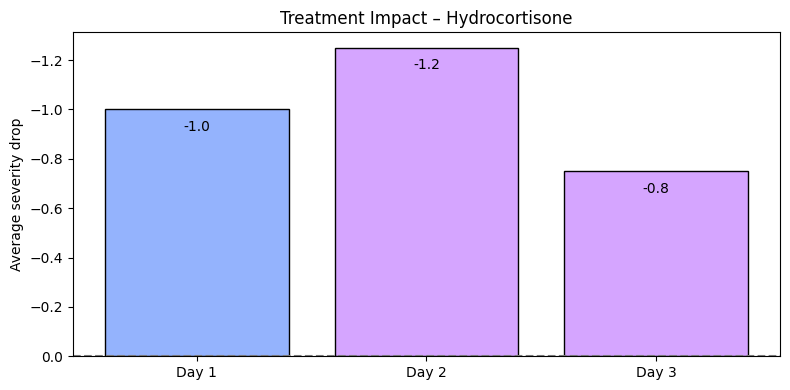

{1: -1.0, 2: -1.25, 3: -0.75}

In [8]:
from app.core.symptoms import treatment_impact
impact = treatment_impact(df, medication="Hydrocortisone", max_lag=3)

import matplotlib.pyplot as plt
import numpy as np
labels = [f"Day {lag}" for lag in impact.keys()]
values = list(impact.values())
colours = ["#94b3fd"] + ["#d5a5ff"] * (len(values) - 1)        # blue, then purple

plt.figure(figsize=(8,4))
bars = plt.bar(labels, values, color=colours, edgecolor="black")
plt.axhline(0, ls="--", color="grey")

# annotate
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h - 0.1*np.sign(h),
             f"{h:.1f}", ha="center", va="top" if h>0 else "bottom")

plt.gca().invert_yaxis()            # bigger drop plots “down”
plt.title("Treatment Impact – Hydrocortisone")
plt.ylabel("Average severity drop")
plt.tight_layout(); plt.show()

impact


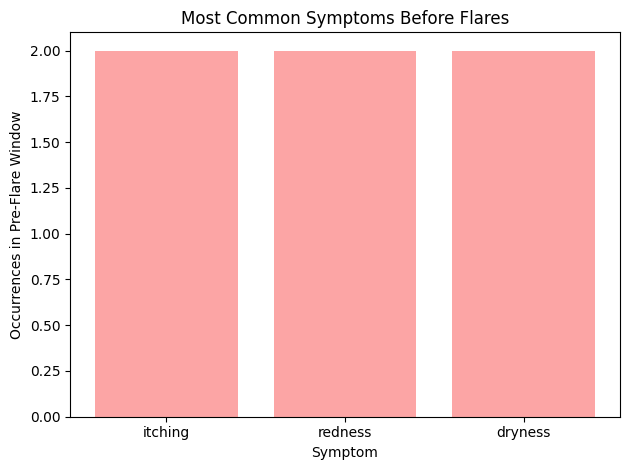

In [ ]:
from app.core.flares import detect_flare_clusters
from collections import defaultdict

window = 3
symptom_counts = defaultdict(int)
flares = detect_flare_clusters(df)

for flare in flares:
    start = flare.start
    window_df = df[(df['date'] >= start - pd.Timedelta(days=window)) & (df['date'] < start)]
    for symptoms in window_df["symptoms"].dropna():
        for s in symptoms:
            symptom_counts[s] += 1
top_symptoms = sorted(symptom_counts.items(), key=lambda x: -x[1])[:5]

import matplotlib.pyplot as plt

symptoms, counts = zip(*top_symptoms)
plt.bar(symptoms, counts, color="#fca5a5")
plt.title("Most Common Symptoms Before Flares")
plt.ylabel("Occurrences in Pre-Flare Window")
plt.xlabel("Symptom")
plt.tight_layout()
plt.show()
